In [1]:
import torch 
import torchvision
import torch.nn as nn 
from IPython.display import Image 
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import PIL
import requests

## Q 3 Saliency maps and adversarial attacks

### Q3.1 Load a pretrained model from torch vision and compute saliency map for predicted class


In [2]:
import torchvision.models as models

In [3]:
! wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2020-10-16 13:03:23--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.100.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.100.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.07s   

2020-10-16 13:03:24 (505 KB/s) - ‘imagenet_class_index.json.1’ saved [35363/35363]



In [4]:
import json
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
# Notice that we apply the same mean and std normalization calculated on train, to both the train and test datasets.
imagenet_transform = transforms.Compose([
                                     transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                                     ])
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
make_viewable = transforms.Compose([
    inv_normalize,
    transforms.ToPILImage()
])

pil = transforms.ToPILImage()

In [6]:
url = "https://cdn.wimmel-napkins.com/F/1/AM/g13312895.jpg"
im = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")

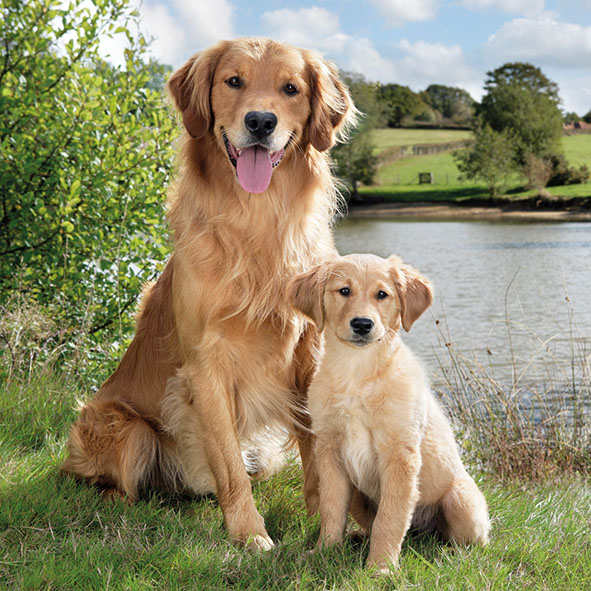

In [7]:
im

### Pass this image through the forward pass of your model to see what the model predicts. For this class, compute the saliency map using the un-normalized score for that class. Details in Sec 3.1 of [1].

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.

IMP: Remember to put the model in eval mode and use un-normalized class scores


In [8]:
def compute_saliency_maps(X, model):
  """
  Compute a class saliency map using the model for image X.
  
  Input:
  - X: Input image, shape is (1, 3, H, W)
  - model: A pretrained CNN that will be used to compute the saliency map.
  
  Returns:
  - saliency: An array of shape (1, H, W) giving the saliency map for the input
    image.
  - predicted_class_id: ID of the class with highest score with respect to 
    which you calculated the saliency map
  """  

  # TODO
  model.eval()
  X.requires_grad_()
  logits = model(X) # unnormalized
  score, predicted_class_id = logits.max(dim=1) # score of the highest class
  score.backward()
  saliency = X.grad.data # (batch, C, H, W)

  # take abs and then take max across 3 channels
  saliency.abs_()
  saliency, i = torch.max(saliency, dim=1) # batch, H, W

  return saliency, predicted_class_id.item()

207 golden_retriever


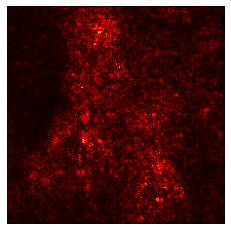

In [9]:
model = models.resnet18(pretrained=True).to(device)
X = imagenet_transform(im).unsqueeze(0).to(device)
saliency, predicted_class_id = compute_saliency_maps(X, model)
print(predicted_class_id, idx2label[predicted_class_id])
plt.imshow(saliency[0].cpu(), cmap=plt.cm.hot)
plt.axis('off')
plt.show()

### Q 3.2 Perform an adversarial attack on the network. Make the model misclassify the example as a target class of your choice by performing gradient ascent in the input space. The resulting image should be imperceptibly different to the human eye from the original image.

In [10]:
def make_fooling_image(X, target_y, model, lr=10000):
  """
  Generate a fooling image that is close to X, but that the model classifies
  as target_y.
  
  Inputs:
  - X: Input image
  - target_y: An integer in the range [0, 1000)
  - model: Pretrained CNN
  
  Returns:
  - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
  """
  # TODO 
  X_fooling = X.clone()
  X_fooling.requires_grad_()
  model.eval()
  for t in range(100):
    logits = model(X_fooling)
    score, predicted_class_id = logits.max(dim=1)
    if predicted_class_id.item() == target_y:
      print("Fooled, at epoch {}".format(t))
      break
    target_score = logits.view(-1)[target_y]
    target_score.backward()

    gradient = X_fooling.grad.data
    # gradient ascent to maximize target_y
    X_fooling.data += lr * (gradient / gradient.norm())
    X_fooling.grad.data.zero_()


  return X_fooling

In [11]:
model = models.resnet18(pretrained=True).to(device)
model.eval() # This is important. Can you guess why? Try commenting it out and see the result ;)
X = imagenet_transform(im).unsqueeze(0).to(device)
target_y = 620 # target label 620 in Imagenet corresponds to the "laptop" class

print(f"Predicted label using X :{idx2label[model(X).max(-1)[1].item()]}")
predicted_label_originally = idx2label[model(X).max(-1)[1].item()]

X_fooling = make_fooling_image(X, target_y=target_y, model=model, lr=1) 

predicted_label_after_fooling = idx2label[model(X_fooling).max(-1)[1].item()]
print(f"Predicted label using X_fooling :{predicted_label_after_fooling }")


Predicted label using X :golden_retriever
Fooled, at epoch 14
Predicted label using X_fooling :laptop


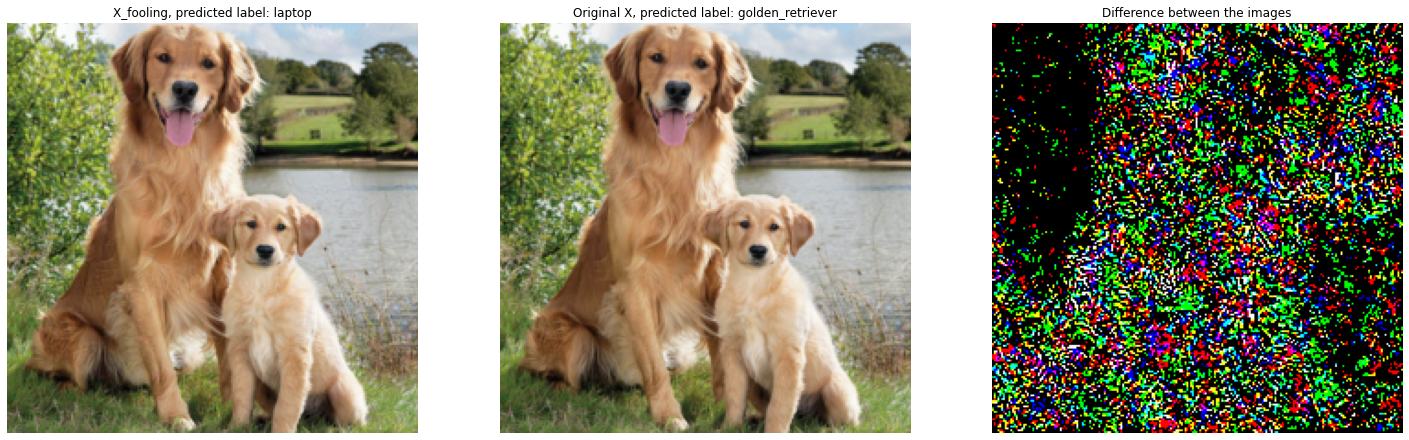

In [12]:
# This cell output is what you should expect to see. 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(25)
f.set_figwidth(25)
#ax1.imshow(to_pil(X_fooling.cpu().squeeze()))
ax1.imshow(pil(inv_normalize(X_fooling.cpu().squeeze())))
ax1.title.set_text(f'X_fooling, predicted label: {predicted_label_after_fooling}')
#ax2.imshow(to_pil(X.cpu().squeeze()))
ax2.imshow(pil(inv_normalize(X.cpu().squeeze())))
ax2.title.set_text(f'Original X, predicted label: {predicted_label_originally}')
ax3.imshow(pil(inv_normalize(X_fooling.cpu().squeeze())- inv_normalize(X.cpu().squeeze())))
ax3.title.set_text(f'Difference between the images')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

### Q 3.3 Now download a different pre-trained model and see what class it predicts originally for the same model, and if our fooling image is also able to fool this other network. This is an instance of black box adversarial attack where without being able to directly optimize using a given model, you are still able to break it!

Hint: For example, try with VGG19. 

In [13]:
model_ = models.vgg19(pretrained=True).to(device)
model_.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
print("Original prediction: {}".format(idx2label[model_(X).argmax().item()]))
print("Fooling image prediction: {}".format(idx2label[model_(X_fooling).argmax().item()]))

Original prediction: golden_retriever
Fooling image prediction: golden_retriever


This fooling image is not able to fool VGG-19. However, if we train another fooling image using a higher learning rate (e.x. $\gamma = 100$), the fooling image would be perceptibly different to the human eye from the original image and it would fool VGG-19 as well.

In [15]:
X_fooling_2 = make_fooling_image(X, target_y=target_y, model=model, lr=100)
print("Original prediction: {}".format(idx2label[model_(X).argmax().item()]))
print("Fooling image prediction: {}".format(idx2label[model_(X_fooling_2).argmax().item()]))

Fooled, at epoch 3
Original prediction: golden_retriever
Fooling image prediction: standard_poodle


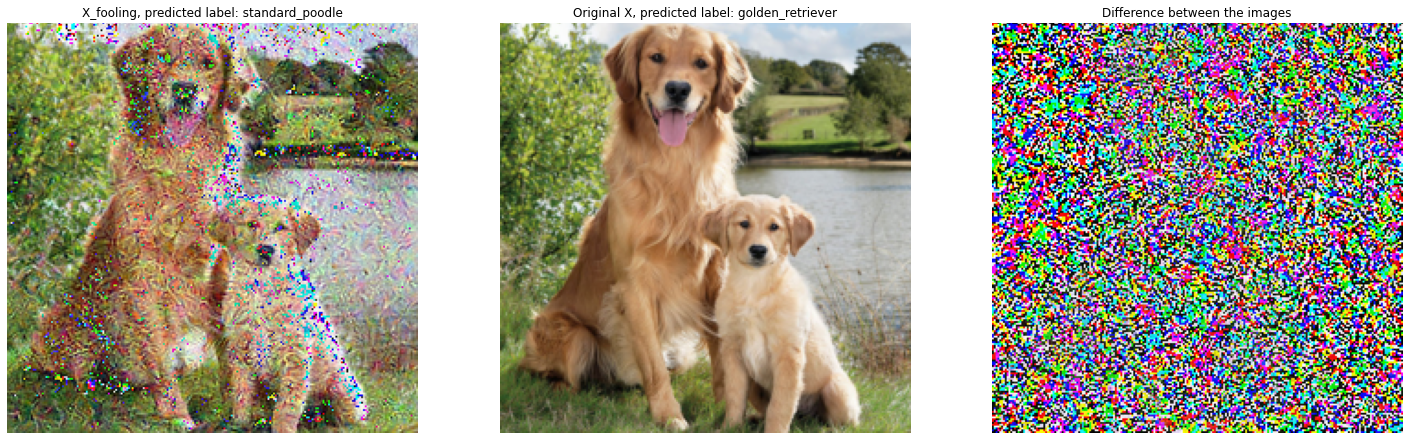

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figheight(25)
f.set_figwidth(25)
#ax1.imshow(to_pil(X_fooling.cpu().squeeze()))
ax1.imshow(pil(inv_normalize(X_fooling_2.cpu().squeeze())))
ax1.title.set_text(f'X_fooling, predicted label: {idx2label[model_(X_fooling_2).argmax().item()]}')
#ax2.imshow(to_pil(X.cpu().squeeze()))
ax2.imshow(pil(inv_normalize(X.cpu().squeeze())))
ax2.title.set_text(f'Original X, predicted label: {predicted_label_originally}')
ax3.imshow(pil(inv_normalize(X_fooling_2.cpu().squeeze())- inv_normalize(X.cpu().squeeze())))
ax3.title.set_text(f'Difference between the images')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

## Q 4 Localisation 

Here we will see how to use a model that was trained using images at a low resolution for localisation of objects in images at higher resolution. Plot the classifier response to the last feature map of the model before average pooling. 



HINT: You will need to use the "IntermediateLayerGetter" functionality to extract the last activations before the final avgpool layer and provide these to the final fully connected layer of the network to get the response. 


In [17]:
from torchvision.models._utils import IntermediateLayerGetter

# Refer to https://github.com/pytorch/vision/blob/master/torchvision/models/_utils.py

imagenet_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

In [18]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")
im = im.resize((int(im.size[0] *2.5), int(im.size[1] * 2.5)))
im

Output hidden; open in https://colab.research.google.com to view.

In [19]:
r50 = torchvision.models.resnet50(pretrained=True).to(device)
X = imagenet_transform(im).unsqueeze(0).to(device)
print(f"Size of input {X.shape}")

Size of input torch.Size([1, 3, 1200, 1600])


In [33]:
import torch.nn.functional as F

def localisation(X, model):
  """
  Generate a localisation map for the predicted class given an input 
  image and a pretrained CNN
  
  Inputs:
  - X: Input image
  - model: Pretrained CNN
  
  Returns:
  - localisation_map : An 2D heatmap of size 38 X 50
  """

  # TODO
  new_model = IntermediateLayerGetter(model, {'layer4': 'feat'})
  new_model.eval()
  model.eval()
  logits = model(X)
  predicted = logits.argmax(dim=1)
  print(predicted.item(), idx2label[predicted.item()])
  last_feature_map = new_model(X)["feat"] # batch=1, channels=2048, H=38, W=50
  response = model.fc.weight[predicted.item(), :]
  localisation_map = torch.matmul(response, F.softmax(last_feature_map.reshape((2048, 38*50)), dim=0)).view(38,50) # 2048 x (2048 (softmaxed across all channels), 38*50) sum of w_k * f_k for f_k of shape (38, 50)
  return localisation_map

281 tabby


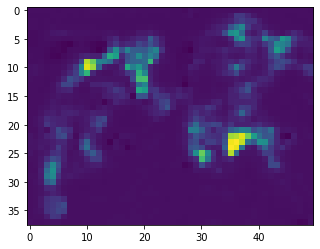

In [34]:
map = localisation(X, r50)
plt.imshow(map.cpu().detach())
plt.show()